
=== 5-fold CV on TRAIN (mean ± std) ===
accuracy : 0.971 ± 0.035
precision: 0.967 ± 0.067
recall   : 0.950 ± 0.100
f1       : 0.953 ± 0.060
roc_auc  : 1.000 ± 0.000

=== FINAL TEST SET METRICS ===
Accuracy : 0.967
Precision: 1.000
Recall   : 0.900  (Patient=1)
F1-score : 0.947
ROC-AUC  : 1.000

=== Confusion Matrix (rows=true, cols=pred) ===
[[20  0]
 [ 1  9]]

=== Classification Report (TEST) ===
              precision    recall  f1-score   support

     Healthy      0.952     1.000     0.976        20
     Patient      1.000     0.900     0.947        10

    accuracy                          0.967        30
   macro avg      0.976     0.950     0.961        30
weighted avg      0.968     0.967     0.966        30



<Figure size 600x500 with 0 Axes>

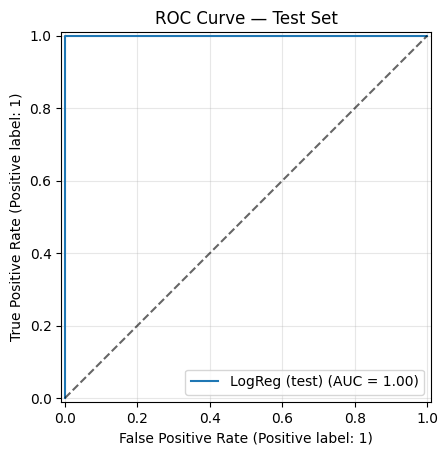

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)

# =============== Load & prepare ===============
df = pd.read_csv("final.csv")

# Map labels to 0/1 (adjust strings if needed)
label_map = {"Healthy": 0, "Patient": 1}
df["class_num"] = df["class"].map(label_map)
assert df["class_num"].isin([0, 1]).all(), "Label mapping failed—check your class strings."

# Features / labels
drop_cols = {"subjectID", "class", "class_num"}
feature_cols = [c for c in df.columns if c not in drop_cols and np.issubdtype(df[c].dtype, np.number)]
X = df[feature_cols].to_numpy()
y = df["class_num"].to_numpy()

# =============== Train / Test split ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True,
)

# =============== Pipeline ===============
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=50, class_weight="balanced", random_state=42)),
])

# =============== CV on TRAIN ONLY ===============
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(
    pipe, X_train, y_train, cv=cv,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    return_train_score=False
)

print("\n=== 5-fold CV on TRAIN (mean ± std) ===")
for m in ["test_accuracy", "test_precision", "test_recall", "test_f1", "test_roc_auc"]:
    vals = cv_scores[m]
    print(f"{m[5:]:<9}: {vals.mean():.3f} ± {vals.std():.3f}")

# =============== Fit on full TRAIN, Evaluate on TEST ===============
pipe.fit(X_train, y_train)

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print("\n=== FINAL TEST SET METRICS ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}  (Patient=1)")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {auc:.3f}")

print("\n=== Confusion Matrix (rows=true, cols=pred) ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred,
                            target_names=["Healthy", "Patient"],
                            digits=3, zero_division=0))

# =============== ROC curve on TEST (optional) ===============
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba, name="LogReg (test)")
plt.plot([0,1],[0,1],'k--',alpha=0.6)
plt.title("ROC Curve — Test Set")
plt.grid(True, alpha=0.3)
plt.show()
